Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.

 Fake News Detection System

 Label Distribution:
label
1    23467
0    21416
Name: count, dtype: int64


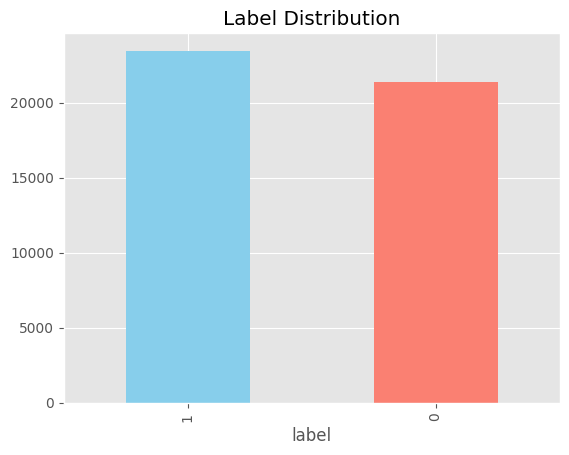


 Feature Extraction with N-grams (1-2)

----------------------------------------
 Logistic Regression

 Evaluating Logistic Regression

 Accuracy: 0.9887

 Classification Report:
              precision    recall  f1-score   support

           0     0.9861    0.9904    0.9882      4283
           1     0.9912    0.9872    0.9892      4694

    accuracy                         0.9887      8977
   macro avg     0.9886    0.9888    0.9887      8977
weighted avg     0.9888    0.9887    0.9888      8977



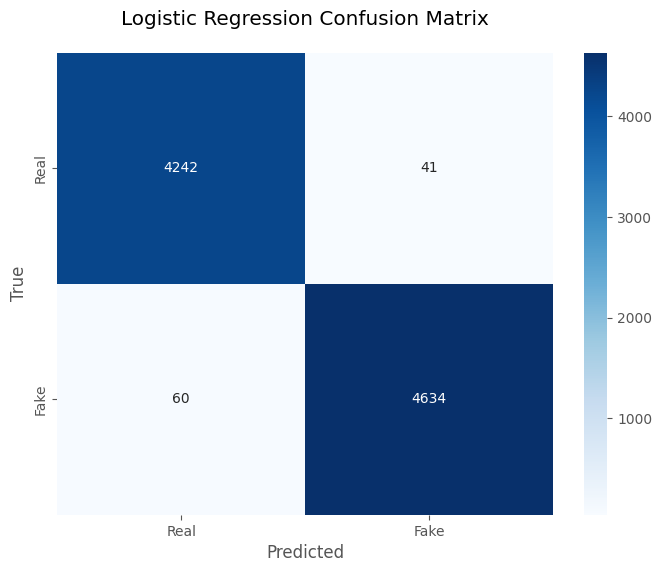


----------------------------------------
 Random Forest

 Evaluating Random Forest

 Accuracy: 0.9981

 Classification Report:
              precision    recall  f1-score   support

           0     0.9972    0.9988    0.9980      4283
           1     0.9989    0.9974    0.9982      4694

    accuracy                         0.9981      8977
   macro avg     0.9981    0.9981    0.9981      8977
weighted avg     0.9981    0.9981    0.9981      8977



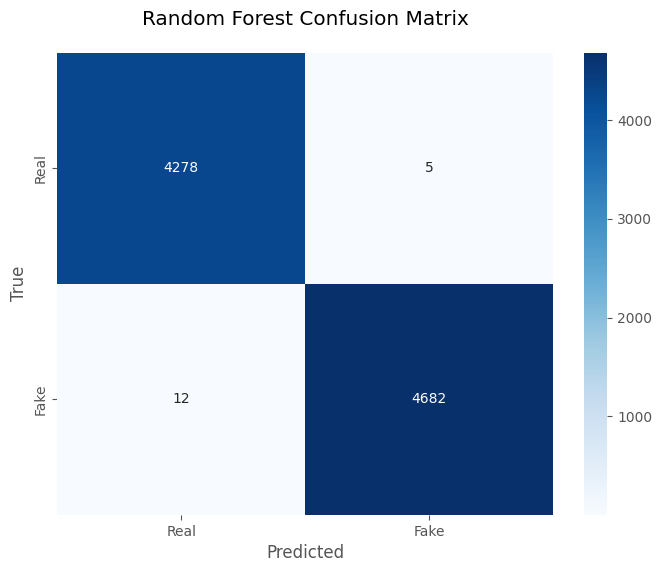


----------------------------------------
 XGBoost

 Evaluating XGBoost

 Accuracy: 0.9979

 Classification Report:
              precision    recall  f1-score   support

           0     0.9967    0.9988    0.9978      4283
           1     0.9989    0.9970    0.9980      4694

    accuracy                         0.9979      8977
   macro avg     0.9978    0.9979    0.9979      8977
weighted avg     0.9979    0.9979    0.9979      8977



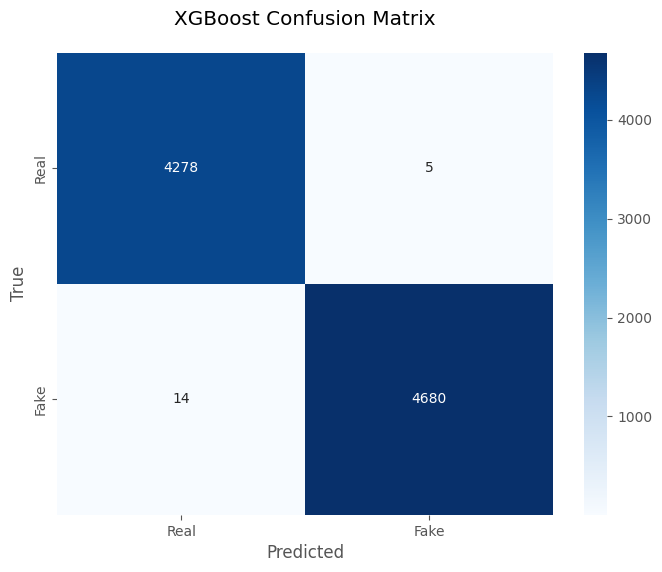


----------------------------------------
 Training Deep Learning Model (PyTorch)
 Epoch 1/5, Loss: 0.0663
 Epoch 2/5, Loss: 0.0107
 Epoch 3/5, Loss: 0.0073
 Epoch 4/5, Loss: 0.0042
 Epoch 5/5, Loss: 0.0037

 Deep Learning Model Accuracy: 0.9943

 Classification Report:
              precision    recall  f1-score   support

           0     0.9953    0.9928    0.9940      4283
           1     0.9934    0.9957    0.9946      4694

    accuracy                         0.9943      8977
   macro avg     0.9944    0.9943    0.9943      8977
weighted avg     0.9943    0.9943    0.9943      8977



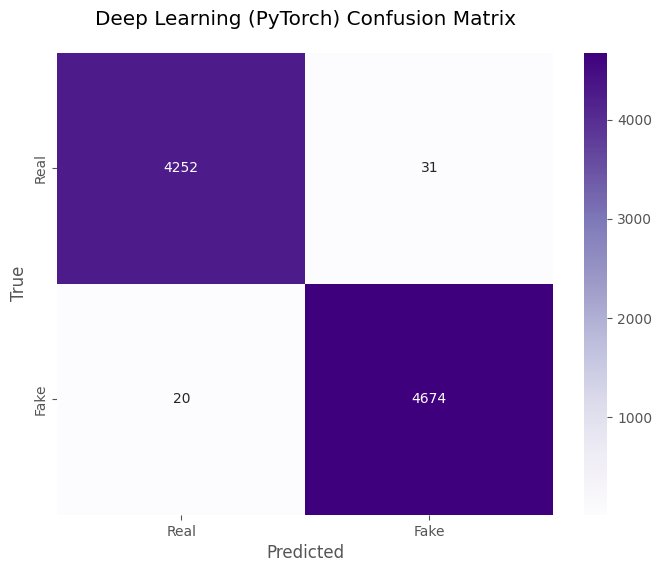


 All tasks completed!


In [2]:
%pip install torch
import pandas as pd
import re
import string
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('ggplot')

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Load and preprocess
def load_data(filepath):
    try:
        df = pd.read_csv(filepath)
        df['text'] = df['text'].astype(str)
        return df
    except FileNotFoundError:
        print(f"\n Error: File not found at {filepath}")
        exit()

def preprocess_text(text, stop_words, lemmatizer):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return ' '.join(words)

def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n{'='*50}")
    print(f" Evaluating {model_name}")
    print("="*50)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"\n Accuracy: {acc:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.title(f'{model_name} Confusion Matrix', pad=20)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# PyTorch Dataset
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Simple Feedforward Neural Network
class FakeNewsNN(nn.Module):
    def __init__(self, input_dim):
        super(FakeNewsNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

def train_deep_learning_model(X_train, X_test, y_train, y_test):
    input_dim = X_train.shape[1]
    batch_size = 32
    epochs = 5
    lr = 0.001

    train_dataset = NewsDataset(X_train, y_train)
    test_dataset = NewsDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FakeNewsNN(input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print("\n" + "-"*40)
    print(" Training Deep Learning Model (PyTorch)")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f" Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (outputs.cpu().numpy() > 0.5).astype(int)
            y_pred.extend(preds.flatten())
    
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Deep Learning Model Accuracy: {acc:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.title('Deep Learning (PyTorch) Confusion Matrix', pad=20)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def main():
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    filepath = 'C:/Users/Abdelrahman Ahmed/Downloads/fake_real_news.csv'
    df = load_data(filepath)
    
    df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
    df['cleaned_content'] = df['content'].apply(lambda x: preprocess_text(x, stop_words, lemmatizer))
    df = df[df['cleaned_content'].str.split().str.len() > 5]
    
    label_cols = ['label', 'is_fake', 'fake', 'target']
    label_column = next((col for col in label_cols if col in df.columns), df.columns[0])
    df['label'] = df[label_column]
    
    print("\n Label Distribution:")
    print(df['label'].value_counts())
    df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Label Distribution')
    plt.show()
    
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_content'], 
        df['label'], 
        test_size=0.2, 
        random_state=42,
        stratify=df['label']
    )
    
    print("\n Feature Extraction with N-grams (1-2)")
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),  
        max_features=5000,
        min_df=5,
        max_df=0.8,
        stop_words='english'
    )
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    print("\n" + "-"*40)
    print(" Logistic Regression")
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_tfidf, y_train)
    evaluate_model(lr, X_test_tfidf, y_test, "Logistic Regression")
    
    print("\n" + "-"*40)
    print(" Random Forest")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_tfidf, y_train)
    evaluate_model(rf, X_test_tfidf, y_test, "Random Forest")
    
    try:
        from xgboost import XGBClassifier
        print("\n" + "-"*40)
        print(" XGBoost")
        xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
        xgb.fit(X_train_tfidf, y_train)
        evaluate_model(xgb, X_test_tfidf, y_test, "XGBoost")
    except ImportError:
        print("\n XGBoost not available")

    # Deep learning model
    train_deep_learning_model(X_train_tfidf, X_test_tfidf, y_train, y_test)

if __name__ == "__main__":
    print("\n Fake News Detection System")
    main()
    print("\n All tasks completed!")
